# ESAVI: 2024


Neste projeto vamos explorar os dados do ESAVI, que correspondem aos dados de Eventos Supostamente Atribuiveis a Vacinação.

Virou uma triste rotina sermos bombardeados por falsas informações na internet. Grande parte dessas notícias se baseiam em teorias da conspiração onde há uma verdade supostamente escondida. Na saúde não é diferente, temos observado um panorama em que cresce o número de informações falsas sobre as vacinas circulando nas redes sociais. Ignorando que há sistemas de controle estabelecidos para a aprovação de uma vacina à população bem como de acompanhamento das reações adversas, o que torna a vacinação um processo bastante seguro e necessário à saúde humana.

Este projeto tem por proposito analisar os dados públicos sobre as possíveis reações adversas fortalecendo o conhecimento sobre as vacinas. Reforçando (1) que não há dados escondidos sobre as vacinas e (2) que existe um monitoramento regular sobre possíveis reações adversas. Com isso espero reforçar que não há vacinas inseguras sendo disponibilizadas para a população.

Os dados do ESAVI estão disponibilizados de forma pública em uma base de dados única. O dicionário dos dados pode ser encontrado no seguinte [link](https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/ESAVI/DicionariodeDados.pdf).

Vamos iniciar o projeto fazendo o upload dos dados via DBFS no databricks. Posteriormente vamos efetuar a modelagem desses dados transformando esses dados em tabelas distintas para facilitar a análise de dados, que será a última etapa do projeto.

## Imports

In [0]:
%pip install pydrive --quiet


Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
!pip install pyspark --quiet

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-54a8a835-8e41-4ced-9b8d-210ad00da297/bin/python -m pip install --upgrade pip' command.


In [0]:
!pip install requests --quiet


You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-54a8a835-8e41-4ced-9b8d-210ad00da297/bin/python -m pip install --upgrade pip' command.


In [0]:
!apt-get install graphviz -y
!pip install graphviz





graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
  Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-54a8a835-8e41-4ced-9b8d-210ad00da297/bin/python -m pip install --upgrade pip' command.


In [0]:
!pip install pydot


  Using cached pydot-3.0.4-py3-none-any.whl (35 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.4
    Not uninstalling pyparsing at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-54a8a835-8e41-4ced-9b8d-210ad00da297
    Can't uninstall 'pyparsing'. No files were found to uninstall.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-54a8a835-8e41-4ced-9b8d-210ad00da297/bin/python -m pip install --upgrade pip' command.


In [0]:
# imports necessarios
import requests
import pandas as pd
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import unicodedata
import re
import pandas as pd
import requests
import zipfile
import io
import graphviz
from graphviz import Digraph
from IPython.display import Image, display
from pyspark.sql.functions import col, to_date, year


In [0]:
#criando a sessao e o contexto que será usado
spark = SparkSession.builder.master("local[*]").getOrCreate()
conf = SparkConf().set('spark.ui.port', '4050').setAppName("srag").setMaster("local[*]")
sc = SparkContext.getOrCreate(conf=conf)

In [0]:
# DEPRECADO por que fiquei com receio do professor não conseguir ler o arquivo.
## Lê o arquivo CSV com Spark
#df1 = spark.read.format("csv") \
#    .option("header", "true") \
#    .option("sep", "|") \
#    .load("dbfs:/FileStore/shared_uploads/melo.katiaselene@gmail.com/esavi-1.csv")

## Converte para DataFrame do pandas
#esavi_data = df1.toPandas()

## Exibe as primeiras linhas
#esavi_data.head()


In [0]:

# Função para normalizar e remover caracteres especiais
def remover_caracteres_especiais(texto):
    if isinstance(texto, str):
        texto = unicodedata.normalize('NFKD', texto)
        texto = texto.encode('ASCII', 'ignore').decode('utf-8')  # Remove acentos
        texto = re.sub(r'[^\w\s]', '', texto)  # Remove caracteres especiais restantes
    return texto


In [0]:


# URL do ZIP no GitHub (exemplo público ou do seu repo)
url = "https://github.com/skmelo/MVP_Estrutura_de_Dados/raw/main/esavi.zip"

# Faz o download do ZIP
response = requests.get(url)

if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        print("Arquivos no ZIP:", z.namelist())  # Lista os arquivos

        # Lê o CSV com codificação correta e separador "|"
        with z.open("esavi.csv") as f:
            df = pd.read_csv(f, sep="|", encoding="latin1")
            print(df.head())
else:
    print("Erro no download:", response.status_code)



Arquivos no ZIP: ['esavi.csv']
                                      nu_notificacao    ds_sexo  \
0  000029813c6eaf176048023399b740b8a5085d737c2a04...  Masculino   
1  00002e19248fa7b5b150687b0e0097ff78b4d78b360f02...   Feminino   
2  000100a041871c0fc89e7f635a0cd5ac8b7d0d8d273d1c...   Feminino   
3  00011568703295ff79fc780063fba2c2df4092789315fd...  Masculino   
4  00015c8d041ffe81d2ea24696697e07af3d7652045a727...  Masculino   

  st_comunidade_tradicional ds_not_mae_filho nu_mes_gestante  \
0                       Não              Não             NaN   
1                       Não              Não               5   
2                       Não              Não             NaN   
3                       Não              Não             NaN   
4                       Não              Não             NaN   

       ds_versao_medra ds_mulher_amamentando ds_profissional_seguranca  \
0  Versão não definida                   NaN                       Não   
1  Versão não definida           

In [0]:
df.head()

,nu_notificacao,ds_sexo,st_comunidade_tradicional,ds_not_mae_filho,nu_mes_gestante,ds_versao_medra,ds_mulher_amamentando,ds_profissional_seguranca,no_estado,dt_recebimento_notificacao,...,dt_aplicacao_imuno,hr_aplica_imuno,ds_nome_fabricante,ds_relacao_imuno,ds_lote_imuno,ds_dose_imuno,ds_imuno,co_imuno,ds_medicamento,ds_relacao_medicamento
0,000029813c6eaf176048023399b740b8a5085d737c2a04...,Masculino,Não,Não,NaN,Versão não definida,NaN,Não,Minas Gerais,NaN,...,14-07-2021#02-10-2021#22-03-2022#25-08-2022,NaN,PFIZER#PFIZER#PFIZER#PFIZER-BELGICA,Suspeito#Suspeito#Suspeito#Suspeito,FA9095#31045BD#FP7082#FT7280,1ª Dose#2ª Dose#Reforço#R2 - 2º Reforço,COVID-19 PFIZER - COMIRNATY#COVID-19 PFIZER - ...,87#87#87#87,NaN,NaN
1,00002e19248fa7b5b150687b0e0097ff78b4d78b360f02...,Feminino,Não,Não,5,Versão não definida,Não,Não,Espírito Santo,NaN,...,06-05-2021,10:00,fiocruz,Suspeito,213vcd035w,D1 - 1ª Dose,Covid-19-Covishield-Oxford/Fiocruz,85,NaN,NaN
2,000100a041871c0fc89e7f635a0cd5ac8b7d0d8d273d1c...,Feminino,Não,Não,NaN,Versão não definida,Não,Não,Pará,25-04-2023,...,11-04-2023,NaN,BAVARIAN,Suspeito,FD800068,D1 - 1ª Dose,Vacina Varíola Bavarian Nordic,100,NaN,NaN
3,00011568703295ff79fc780063fba2c2df4092789315fd...,Masculino,Não,Não,NaN,Versão não definida,NaN,Não,Paraná,08-04-2021,...,01-04-2021,NaN,BUTANTAN,Suspeito,210040,D2 - 2ª Dose,Covid-19-Coronavac-Sinovac/Butantan,86,NaN,NaN
4,00015c8d041ffe81d2ea24696697e07af3d7652045a727...,Masculino,Não,Não,NaN,Versão não definida,NaN,Não,Minas Gerais,NaN,...,26-11-2021#26-07-2022,NaN,PFIZER#PFIZER-BELGICA,Suspeito#Suspeito,FM3809#7082,2ª Dose#D3 - 3ª Dose,COVID-19 PFIZER - COMIRNATY#Vacina Covid-19-RN...,87#87,NaN,NaN


In [0]:
esavi_data = df.applymap(remover_caracteres_especiais)
esavi_data.head()

,nu_notificacao,ds_sexo,st_comunidade_tradicional,ds_not_mae_filho,nu_mes_gestante,ds_versao_medra,ds_mulher_amamentando,ds_profissional_seguranca,no_estado,dt_recebimento_notificacao,...,dt_aplicacao_imuno,hr_aplica_imuno,ds_nome_fabricante,ds_relacao_imuno,ds_lote_imuno,ds_dose_imuno,ds_imuno,co_imuno,ds_medicamento,ds_relacao_medicamento
0,000029813c6eaf176048023399b740b8a5085d737c2a04...,Masculino,Nao,Nao,NaN,Versao nao definida,NaN,Nao,Minas Gerais,NaN,...,14072021021020212203202225082022,NaN,PFIZERPFIZERPFIZERPFIZERBELGICA,SuspeitoSuspeitoSuspeitoSuspeito,FA909531045BDFP7082FT7280,1a Dose2a DoseReforcoR2 2o Reforco,COVID19 PFIZER COMIRNATYCOVID19 PFIZER COMIR...,87878787,NaN,NaN
1,00002e19248fa7b5b150687b0e0097ff78b4d78b360f02...,Feminino,Nao,Nao,5,Versao nao definida,Nao,Nao,Espirito Santo,NaN,...,06052021,1000,fiocruz,Suspeito,213vcd035w,D1 1a Dose,Covid19CovishieldOxfordFiocruz,85,NaN,NaN
2,000100a041871c0fc89e7f635a0cd5ac8b7d0d8d273d1c...,Feminino,Nao,Nao,NaN,Versao nao definida,Nao,Nao,Para,25042023,...,11042023,NaN,BAVARIAN,Suspeito,FD800068,D1 1a Dose,Vacina Variola Bavarian Nordic,100,NaN,NaN
3,00011568703295ff79fc780063fba2c2df4092789315fd...,Masculino,Nao,Nao,NaN,Versao nao definida,NaN,Nao,Parana,08042021,...,01042021,NaN,BUTANTAN,Suspeito,210040,D2 2a Dose,Covid19CoronavacSinovacButantan,86,NaN,NaN
4,00015c8d041ffe81d2ea24696697e07af3d7652045a727...,Masculino,Nao,Nao,NaN,Versao nao definida,NaN,Nao,Minas Gerais,NaN,...,2611202126072022,NaN,PFIZERPFIZERBELGICA,SuspeitoSuspeito,FM38097082,2a DoseD3 3a Dose,COVID19 PFIZER COMIRNATYVacina Covid19RNAm Pf...,8787,NaN,NaN


Agora vamos obter a descrição da tabela de dados com o intuito de entender melhor esses dados para o processo de modelagem.

In [0]:
#Puxando o nome das colunas individualmente
esavi_data.columns

Out[12]: Index(['nu_notificacao', 'ds_sexo', 'st_comunidade_tradicional',
       'ds_not_mae_filho', 'nu_mes_gestante', 'ds_versao_medra',
       'ds_mulher_amamentando', 'ds_profissional_seguranca', 'no_estado',
       'dt_recebimento_notificacao', 'ds_raca_cor_mae', 'ds_gestante',
       'no_estado_notificacao', 'dt_desfecho', 'nu_idade', 'ds_raca_cor',
       'no_municipio', 'ds_crianca_aleitamento', 'ds_estrangeiro',
       'ds_profissional_saude', 'no_estado_mae', 'no_mun_mae',
       'ds_medicamento_uso', 'ds_atendimento_medico', 'dt_investigacao',
       'ds_mae_gestante', 'nu_mes_gestacao_mae', 'ds_mae_amamentando',
       'dt_notificacao', 'ds_situacao_notificacao', 'no_mun_notificacao',
       'ds_evolucao_caso', 'ds_tipo_atendimento',
       'no_estado_estab_atendimento', 'dt_admissao_atendimento',
       'no_mun_estab_atendimento', 'dt_alta_atendimento', 'ds_evento_adverso',
       'ds_casualidade', 'ds_conduta', 'ds_diagnostico',
       'ds_doencas_pre_existentes', 'dt_enc

In [0]:
# Checando se há linhas com dados vazios
esavi_data["nu_notificacao"].isnull().any()

Out[13]: False

In [0]:
esavi_data["nu_notificacao"].value_counts()


Out[14]:       BELGIUM NV  BELGICA                                           8
      BELGIUM NV  BELGICAPFIZER                                     4
980d67833fa2b520150471ee45c5ecbaa4575e48deb95baa8e26fbe498af28e8    4
585a250dd51e519910e9f0fdcef52ae9fffc24d4d7269d7b4ce8d53706cb9b4e    3
9ca71effc3e0e168e1ab4c4fe042f0abaa1fbd7523637aed62dd9f401f3c9838    3
                                                                   ..
5567301e6b95204a130dd2ab4852e105b2dd5fed737eff96806f10911365e464    1
55674ddd75250bf847b91b7be741963db0c84b905322ba0746772422623187d5    1
5567855074881258944a027e2b02e51618958beae767a8899d5a55002c3a2edd    1
5567f8a61925d1491278484503490a811f8bce308df4a4cebb3746838ee8bac1    1
ffffd8ba0f65fcd3d48ea395f9dadc60d8b2429d7238cd54a05b30aafc7c9de4    1
Name: nu_notificacao, Length: 279860, dtype: int64

No comando acima conseguimos identificar que tem algumas linhas com valores incorretos para o campo nu_notificacao. Vamos entender com mais detalhes.

In [0]:
valores = ["BELGIUM"]

# Remove espaços extras das strings
valores = [val.strip() for val in valores]

# Filtra as linhas onde a coluna 'nu_notificacao' contém algum dos valores
resultado = esavi_data[esavi_data["nu_notificacao"].str.contains('|'.join(valores), na=False)]

# Exibe o resultado
print(resultado)


                                           nu_notificacao  \
24529                                 BELGIUM NV  BELGICA   
24860         BELGIUM NV  BELGICAPFIZER MANUFACTURING ...   
56621            BELGIUM NV  BELGICAPFIZER MANUFACTURING    
56622         BELGIUM NV  BELGICAMINISTERIO DA SAUDEMI...   
57771                                 BELGIUM NV  BELGICA   
86439                           BELGIUM NV  BELGICAPFIZER   
86839              BELGIUM NV  BELGICAMINISTERIO DA SAUDE   
89880         BELGIUM NV  BELGICAPFIZERBIONTECHPFIZERP...   
100311                                BELGIUM NV  BELGICA   
107162                                BELGIUM NV  BELGICA   
118252           BELGIUM NV  BELGICAPFIZER MANUFACTURING    
118253        BELGIUM NV  BELGICAFUNDACAO OSWALDO CRUZ...   
120328                                BELGIUM NV  BELGICA   
140871                                BELGIUM NV  BELGICA   
142032                          BELGIUM NV  BELGICAPFIZER   
144838                  

Considerando que são apenas 19 linhas, e esse padrão também foi encontrado no csv, por simplicidade vamos fazer a remoção dessas linhas.

In [0]:
# Remove as linhas onde a coluna 'nu_notificacao' contém algum dos valores
esavi_data_filtrado = esavi_data[~esavi_data["nu_notificacao"].str.contains('|'.join(valores), na=False)]



In [0]:
# checando se deu certo a remocao
esavi_data_filtrado["nu_notificacao"].value_counts()


Out[17]: 980d67833fa2b520150471ee45c5ecbaa4575e48deb95baa8e26fbe498af28e8    4
585a250dd51e519910e9f0fdcef52ae9fffc24d4d7269d7b4ce8d53706cb9b4e    3
2ff382ed9752b16c3d3cd6b7007632c3915eafcf2bad9c787b7fcf69449f264e    3
e5db618f428d87f71d06392ee5a84db7850dcef7a00ec4bc48aeb0d9331557ac    3
d4bd2c148a75dfde0a945e7068e83797c92d42bea1890276d1e9aa46d05bc64a    3
                                                                   ..
5567855074881258944a027e2b02e51618958beae767a8899d5a55002c3a2edd    1
5567f8a61925d1491278484503490a811f8bce308df4a4cebb3746838ee8bac1    1
5567f8f276cf34340276c6bc2aa233f681df89adffd61d4721c10a487d422978    1
55680f5302a98d3a39fd0cf02a2b53b27f92f03d0142ecb4a6f0786fc9f5a78e    1
ffffd8ba0f65fcd3d48ea395f9dadc60d8b2429d7238cd54a05b30aafc7c9de4    1
Name: nu_notificacao, Length: 279852, dtype: int64

In [0]:
esavi_data_filtrado.describe(include='all')


,nu_notificacao,ds_sexo,st_comunidade_tradicional,ds_not_mae_filho,nu_mes_gestante,ds_versao_medra,ds_mulher_amamentando,ds_profissional_seguranca,no_estado,dt_recebimento_notificacao,...,dt_aplicacao_imuno,hr_aplica_imuno,ds_nome_fabricante,ds_relacao_imuno,ds_lote_imuno,ds_dose_imuno,ds_imuno,co_imuno,ds_medicamento,ds_relacao_medicamento
count,279921,279919,248007,279919,5438,268365,177020,277361,279919,131504,...,277793,111923,258241,279904,269219,279904,279904,279904,22803,22803
unique,279852,2,2,2,10,1,2,2,27,1431,...,44218,4334,10421,240,76584,6570,10886,8098,16250,230
top,980d67833fa2b520150471ee45c5ecbaa4575e48deb95b...,Feminino,Nao,Nao,1,Versao nao definida,Nao,Nao,Minas Gerais,02022021,...,01022021,1000,FIOCRUZ,Suspeito,4120Z005,D1 1a Dose,Covid19CoronavacSinovacButantan,85,LOSARTANA,Concomitante
freq,4,177019,245617,276874,964,268365,174571,275067,52945,1122,...,2824,15721,30261,186135,12715,106462,28836,71051,405,6229
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Agora os dados do dataset parecem mais coerentes. Vamos seguir para a modelagem desse banco de dados.



In [0]:
esavi_data_filtrado.columns

Out[19]: Index(['nu_notificacao', 'ds_sexo', 'st_comunidade_tradicional',
       'ds_not_mae_filho', 'nu_mes_gestante', 'ds_versao_medra',
       'ds_mulher_amamentando', 'ds_profissional_seguranca', 'no_estado',
       'dt_recebimento_notificacao', 'ds_raca_cor_mae', 'ds_gestante',
       'no_estado_notificacao', 'dt_desfecho', 'nu_idade', 'ds_raca_cor',
       'no_municipio', 'ds_crianca_aleitamento', 'ds_estrangeiro',
       'ds_profissional_saude', 'no_estado_mae', 'no_mun_mae',
       'ds_medicamento_uso', 'ds_atendimento_medico', 'dt_investigacao',
       'ds_mae_gestante', 'nu_mes_gestacao_mae', 'ds_mae_amamentando',
       'dt_notificacao', 'ds_situacao_notificacao', 'no_mun_notificacao',
       'ds_evolucao_caso', 'ds_tipo_atendimento',
       'no_estado_estab_atendimento', 'dt_admissao_atendimento',
       'no_mun_estab_atendimento', 'dt_alta_atendimento', 'ds_evento_adverso',
       'ds_casualidade', 'ds_conduta', 'ds_diagnostico',
       'ds_doencas_pre_existentes', 'dt_enc

## Modelagem do banco de Dados

### Modelo Conceitual
Analisando a base de dados podemos definir como entidades:
- Evento: aspectos relacionados à ocorrência de evento adverso, gravidade e conclusão da investigação.
    - nu_notificacao (primary key),dt_notificacao, dt_recebimento_notificacao,ds_situacao_notificacao, dt_desfecho, ds_atendimento_medico, dt_investigacao, ds_evolucao_caso, ds_evento_adverso, ds_casualidade, ds_conduta, ds_diagnostico, dt_encerramento,ds_encerramento_grave,ds_tipo_encerramento, ds_class_gravidade_ea, ds_reacao_ea, ds_dia_duracao_ea 
- Vacinas: vacina e outros medicamentos registrados como possiveis motivadores do evento adverso.
    - ds_nome_fabricante, ds_estrategia_imuno, dt_aplicacao_imuno, ds_relacao_imuno, ds_lote_imuno, ds_dose_imuno, ds_imuno, co_imuno
- Medicamentos:
    - ds_medicamento_uso, ds_relacao_medicamento, ds_medicamento
- Paciente: dados demograficos do paciente que teve o efeito adverso registrado
    - ds_sexo, nu_mes_gestante, ds_mulher_amamentando, ds_profissional_seguranca,ds_estrangeiro,st_comunidade_tradicional, ds_raca_cor_mae, ds_gestante, nu_idade, ds_raca_cor, ds_profissional_saude,ds_doencas_pre_existentes
- Localidade: dados da unidade de saude e localidade.
    - no_estado, no_municipio, no_mun_notificacao,no_estado_notificacao, ds_tipo_atendimento

In [0]:

# Cria o grafo
dot = Digraph(comment='Modelo Conceitual ESAVI')

# Entidades
dot.node('Evento', 'Evento')
dot.node('Vacina', 'Vacina')
dot.node('Medicamento', 'Medicamento')
dot.node('Paciente', 'Paciente')
dot.node('Localidade', 'Localidade')

# Relacionamentos
dot.edge('Evento', 'Vacina', label='1:N')
dot.edge('Evento', 'Medicamento', label='1:N')
dot.edge('Evento', 'Paciente', label='1:1')
dot.edge('Evento', 'Localidade', label='1:1')

# Caminho completo no DBFS
output_path = "/dbfs/FileStore/shared_uploads/melo.katiaselene@gmail.com/modelo_conceitual_esavi"

# Renderiza o diagrama
dot.render(output_path, format='png', cleanup=True)

print("Diagrama salvo em:", output_path + ".png")


Diagrama salvo em: /dbfs/FileStore/shared_uploads/melo.katiaselene@gmail.com/modelo_conceitual_esavi.png


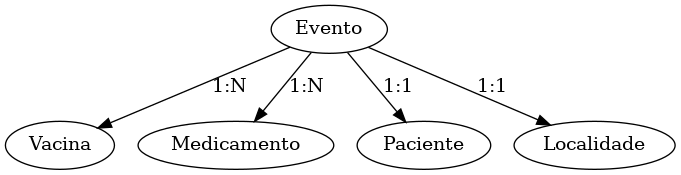

In [0]:

display(Image("/dbfs/FileStore/shared_uploads/melo.katiaselene@gmail.com/modelo_conceitual_esavi.png"))


### Modelo lógico

Agora que criamos o modelo teórico vamos definir o modelo lógico com base nas colunas que definimos acima.

In [0]:
spark.sql("CREATE DATABASE IF NOT EXISTS katiamelo_mvp_engenharia_dados")
spark.sql("USE katiamelo_mvp_engenharia_dados")


Out[22]: DataFrame[]

In [0]:
# Tabela Evento
spark.sql("""
CREATE TABLE IF NOT EXISTS evento (
    nu_notificacao STRING,
    dt_notificacao DATE,
    dt_recebimento_notificacao DATE,
    ds_situacao_notificacao STRING,
    dt_desfecho DATE,
    ds_atendimento_medico STRING,
    dt_investigacao DATE,
    ds_evolucao_caso STRING,
    ds_evento_adverso STRING,
    ds_casualidade STRING,
    ds_conduta STRING,
    ds_diagnostico STRING,
    dt_encerramento DATE,
    ds_encerramento_grave STRING,
    ds_tipo_encerramento STRING,
    ds_class_gravidade_ea STRING,
    ds_reacao_ea STRING,
    ds_dia_duracao_ea INT
)
USING DELTA
""")

# Tabela Vacina
spark.sql("""
CREATE TABLE IF NOT EXISTS vacina (
    nu_notificacao STRING,
    ds_nome_fabricante STRING,
    ds_estrategia_imuno STRING,
    dt_aplicacao_imuno DATE,
    ds_relacao_imuno STRING,
    ds_lote_imuno STRING,
    ds_dose_imuno STRING,
    ds_imuno STRING,
    co_imuno STRING
)
USING DELTA
""")

# Tabela Medicamento
spark.sql("""
CREATE TABLE IF NOT EXISTS medicamento (
    nu_notificacao STRING,
    ds_medicamento_uso STRING,
    ds_relacao_medicamento STRING,
    ds_medicamento STRING
)
USING DELTA
""")

# Tabela Paciente
spark.sql("""
CREATE TABLE IF NOT EXISTS paciente (
    nu_notificacao STRING,
    ds_sexo STRING,
    nu_mes_gestante INT,
    ds_mulher_amamentando STRING,
    ds_profissional_seguranca STRING,
    ds_estrangeiro STRING,
    st_comunidade_tradicional STRING,
    ds_raca_cor_mae STRING,
    ds_gestante STRING,
    nu_idade INT,
    ds_raca_cor STRING,
    ds_profissional_saude STRING,
    ds_doencas_pre_existentes STRING
)
USING DELTA
""")

# Tabela Localidade
spark.sql("""
CREATE TABLE IF NOT EXISTS localidade (
    nu_notificacao STRING,
    no_estado STRING,
    no_municipio STRING,
    no_mun_notificacao STRING,
    no_estado_notificacao STRING,
    ds_tipo_atendimento STRING
)
USING DELTA
""")


Out[23]: DataFrame[]

In [0]:
#checando se as tabelas foram criadas
spark.sql("SHOW TABLES").show(truncate=False)


+------------------------------+-----------+-----------+
|database                      |tableName  |isTemporary|
+------------------------------+-----------+-----------+
|katiamelo_mvp_engenharia_dados|evento     |false      |
|katiamelo_mvp_engenharia_dados|localidade |false      |
|katiamelo_mvp_engenharia_dados|medicamento|false      |
|katiamelo_mvp_engenharia_dados|paciente   |false      |
|katiamelo_mvp_engenharia_dados|pessoa     |false      |
|katiamelo_mvp_engenharia_dados|vacina     |false      |
+------------------------------+-----------+-----------+



In [0]:
#preparando o arquivo para fazer o carregamento nas tabelas
esavi_spark = spark.createDataFrame(esavi_data_filtrado)


Agora vamos adicionar os dados esavi nas tabelas criadas

In [0]:
# Salvando dados na tabela evento
evento_cols = [
    "nu_notificacao", "dt_notificacao", "dt_recebimento_notificacao",
    "ds_situacao_notificacao", "dt_desfecho", "ds_atendimento_medico",
    "dt_investigacao", "ds_evolucao_caso", "ds_evento_adverso",
    "ds_casualidade", "ds_conduta", "ds_diagnostico", "dt_encerramento",
    "ds_encerramento_grave", "ds_tipo_encerramento", "ds_class_gravidade_ea",
    "ds_reacao_ea", "ds_dia_duracao_ea"
]
evento_df = esavi_spark.select(evento_cols)
evento_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("evento")


In [0]:
# checando se os dados foram armazenados corretamente
spark.sql("SELECT * FROM evento LIMIT 10").show()

+--------------------+--------------+--------------------------+-----------------------+-----------+---------------------+---------------+-----------------+--------------------+--------------------+---------------+--------------------+----------------+---------------------+--------------------+---------------------+--------------------+-----------------+
|      nu_notificacao|dt_notificacao|dt_recebimento_notificacao|ds_situacao_notificacao|dt_desfecho|ds_atendimento_medico|dt_investigacao| ds_evolucao_caso|   ds_evento_adverso|      ds_casualidade|     ds_conduta|      ds_diagnostico| dt_encerramento|ds_encerramento_grave|ds_tipo_encerramento|ds_class_gravidade_ea|        ds_reacao_ea|ds_dia_duracao_ea|
+--------------------+--------------+--------------------------+-----------------------+-----------+---------------------+---------------+-----------------+--------------------+--------------------+---------------+--------------------+----------------+---------------------+------------

In [0]:
# Salvando dados na tabela vacina
vacina_cols = [
    "nu_notificacao", "ds_nome_fabricante", "ds_estrategia_imuno",
    "dt_aplicacao_imuno", "ds_relacao_imuno", "ds_lote_imuno",
    "ds_dose_imuno", "ds_imuno", "co_imuno"
]
vacina_df = esavi_spark.select(vacina_cols)
vacina_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("vacina")


In [0]:
# checando se os dados foram armazenados corretamente
spark.sql("SELECT * FROM vacina LIMIT 10").show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
|      nu_notificacao|  ds_nome_fabricante| ds_estrategia_imuno|  dt_aplicacao_imuno|    ds_relacao_imuno|       ds_lote_imuno|       ds_dose_imuno|            ds_imuno|co_imuno|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
|000029813c6eaf176...|PFIZERPFIZERPFIZE...|Campanha indiscri...|14072021021020212...|SuspeitoSuspeitoS...|FA909531045BDFP70...|1a Dose2a DoseRef...|COVID19 PFIZER  C...|87878787|
|00002e19248fa7b5b...|             fiocruz|      Intensificacao|            06052021|            Suspeito|          213vcd035w|         D1  1a Dose|Covid19Covishield...|      85|
|000100a041871c0fc...|            BAVARIAN|              Rotina|            11042023|            Suspeito

In [0]:
# Salvando dados na tabela vacina
medicamento_cols = [
    "nu_notificacao", "ds_medicamento_uso", "ds_relacao_medicamento", "ds_medicamento"
]
medicamento_df = esavi_spark.select(medicamento_cols)
medicamento_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("medicamento")


In [0]:
# checando se os dados foram armazenados corretamente
spark.sql("SELECT * FROM medicamento LIMIT 10").show()

+--------------------+------------------+----------------------+--------------+
|      nu_notificacao|ds_medicamento_uso|ds_relacao_medicamento|ds_medicamento|
+--------------------+------------------+----------------------+--------------+
|000029813c6eaf176...|              null|                  null|          null|
|00002e19248fa7b5b...|              null|                  null|          null|
|000100a041871c0fc...|               Nao|                  null|          null|
|00011568703295ff7...|               Nao|                  null|          null|
|00015c8d041ffe81d...|              null|                  null|          null|
|000195e41cde75a23...|               Nao|                  null|          null|
|00019e5a1fbf5215e...|               Nao|                  null|          null|
|0001b77aaa03b03aa...|               Sim|          Concomitante|       ALENTUS|
|0001b9499e6639fb1...|              null|                  null|          null|
|0001c6aa1612e0e71...|               Nao

In [0]:
paciente_cols = [
    "nu_notificacao", "ds_sexo", "nu_mes_gestante", "ds_mulher_amamentando",
    "ds_profissional_seguranca", "ds_estrangeiro", "st_comunidade_tradicional",
    "ds_raca_cor_mae", "ds_gestante", "nu_idade", "ds_raca_cor",
    "ds_profissional_saude", "ds_doencas_pre_existentes"
]
paciente_df = esavi_spark.select(paciente_cols)
paciente_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("paciente")


In [0]:
# checando se os dados foram armazenados corretamente
spark.sql("SELECT * FROM paciente LIMIT 10").show()

+--------------------+---------+---------------+---------------------+-------------------------+--------------+-------------------------+---------------+-----------+--------+-----------+---------------------+-------------------------+
|      nu_notificacao|  ds_sexo|nu_mes_gestante|ds_mulher_amamentando|ds_profissional_seguranca|ds_estrangeiro|st_comunidade_tradicional|ds_raca_cor_mae|ds_gestante|nu_idade|ds_raca_cor|ds_profissional_saude|ds_doencas_pre_existentes|
+--------------------+---------+---------------+---------------------+-------------------------+--------------+-------------------------+---------------+-----------+--------+-----------+---------------------+-------------------------+
|000029813c6eaf176...|Masculino|           null|                 null|                      Nao|          null|                      Nao|           null|       null|    36.0|   Ignorado|                  Nao|                     null|
|00002e19248fa7b5b...| Feminino|              5|            

In [0]:
localidade_cols = [
    "nu_notificacao", "no_estado", "no_municipio", 
    "no_mun_notificacao", "no_estado_notificacao", "ds_tipo_atendimento"
]
localidade_df = esavi_spark.select(localidade_cols)
localidade_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("localidade")


In [0]:
# checando se os dados foram armazenados corretamente
spark.sql("SELECT * FROM localidade LIMIT 10").show()

+--------------------+-----------------+--------------------+--------------------+---------------------+--------------------+
|      nu_notificacao|        no_estado|        no_municipio|  no_mun_notificacao|no_estado_notificacao| ds_tipo_atendimento|
+--------------------+-----------------+--------------------+--------------------+---------------------+--------------------+
|000029813c6eaf176...|     Minas Gerais|             Araujos|             Araujos|         Minas Gerais|                null|
|00002e19248fa7b5b...|   Espirito Santo|Venda Nova do Imi...|Venda Nova do Imi...|       Espirito Santo|                null|
|000100a041871c0fc...|             Para|               Belem|               Belem|                 Para|                null|
|00011568703295ff7...|           Parana|           Guaratuba|           Guaratuba|               Parana|Ambulatorioconsul...|
|00015c8d041ffe81d...|     Minas Gerais|      Belo Horizonte|      Belo Horizonte|         Minas Gerais|              

### Analise de Dados

Como há uma limitação de tempo para a execução dessa investigação responderemos apenas algumas perguntas básicas:
- **Qual o volume de casos de reações adversas anual?**
- **Qual o tipo de evento adverso**?
- **Qual o imuno mais teve evento adverso?** 
- **Do volume de eventos adversos anuais quantos foram graves?**
- **Os eventos graves envolviam doenças pre existentes?**
- **Qual a prevalência de casos entre os sexos?**
- **Qual a prevalência de casos entre as raças?**
- **Qual a conduta adotada para os casos?**
- **Qual foi o diagnotisco dos casos?**

Há diversas outras perguntas que poderiam ser respondidas com os dados, vamos nos concentrar nessas mais simples por ora, considerando que o escopo do MVP não é um aprofundamento muito grande nas análises de dados.

**Qual o volume de casos de reações adversas anual?**

Como podemos observar abaixo os eventos adversos relacionados a vacinação são bastante raros. Aumentou consideravelmente no período pós pandemia, o que pode estar influenciado por fatores como: (1) desconfiança da população em relação a vacina da covid-19 bem como ao fato de que a vacinação foi emergencial dado as características da pandemia.

Vamos investigar especificamente os últimos anos de 2021-2024 e verificar quais foram os tipos de eventos adversos e sua gravidade.

In [0]:

# Converte a coluna 'dt_notificacao' para o tipo DATE usando o formato 'ddMMyyyy'
evento_df = evento_df.withColumn('dt_notificacao_date', to_date(col('dt_notificacao'), 'ddMMyyyy'))

volume_anual_df = evento_df.select(
    year(col('dt_notificacao_date')).alias('ano'),
    col('nu_notificacao')
).groupBy('ano').count().withColumnRenamed('count', 'volume_casos')

# Exibir os resultados
volume_anual_df.orderBy(col('ano').desc()).toPandas()


,ano,volume_casos
0,2024.0,28061
1,2023.0,34374
2,2022.0,56759
3,2021.0,160383
4,2020.0,192
5,2019.0,73
6,2018.0,10
7,2017.0,3
8,2016.0,1
9,2015.0,1


In [0]:
# Converte 'dt_notificacao' para tipo DATE
evento_df = evento_df.withColumn(
    'dt_notificacao_date',
    to_date(col('dt_notificacao'), 'ddMMyyyy')
)

# Extrai o ano
evento_df = evento_df.withColumn('ano', year(col('dt_notificacao_date')))

# Cria coluna categórica baseada em 'ds_encerramento_grave'
evento_df = evento_df.withColumn(
    'condicao_grave',
    when(col('ds_encerramento_grave').rlike("(?i)sim"), 'grave').otherwise('nao grave')
)

# Filtra os anos de interesse
evento_filtrado = evento_df.filter((col('ano') >= 2021) & (col('ano') <= 2024))

# Pivotando com a nova coluna
volume_pivotado = evento_filtrado.groupBy('ano') \
    .pivot('condicao_grave') \
    .agg(count('nu_notificacao')) \
    .orderBy(col('ano').desc())

# Exibe como tabela
volume_pivotado.toPandas()


,ano,grave,nao grave
0,2024,1431,26630
1,2023,2305,32069
2,2022,3173,53586
3,2021,9928,150455


In [0]:

volume_percentual = volume_pivotado.withColumn(
    "percentual_grave",
    expr("grave * 100.0 / (grave + `nao grave`)")
)
volume_percentual.toPandas()


/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [percentual_grave] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


,ano,grave,nao grave,percentual_grave
0,2024,1431,26630,5.09960443319910
1,2023,2305,32069,6.70564961889800
2,2022,3173,53586,5.59030285945841
3,2021,9928,150455,6.19018225123610


Como podemos observar acima a maior parte dos eventos adversos registrados nesses anos não eram graves.

In [0]:
# Converte a coluna 'dt_notificacao' de string para date
evento_df = evento_df.withColumn(
    'dt_notificacao_date',
    to_date(col('dt_notificacao'), 'ddMMyyyy')
)

# Cria coluna de ano
evento_df = evento_df.withColumn('ano', year(col('dt_notificacao_date')))

# Filtra apenas os anos desejados (de 2021 a 2024)
evento_filtrado = evento_df.filter((col('ano') >= 2021) & (col('ano') <= 2024))

# Pivotando os dados: colunas = valores únicos de ds_conduta, linhas = anos
volume_pivotado = evento_filtrado.groupBy('ano') \
    .pivot('ds_conduta') \
    .agg(count('nu_notificacao')) \
    .orderBy(col('ano').desc())

# Converte para Pandas para exibir como tabela
volume_pivotado.toPandas()


,ano,null,Contra indicacao com substituicao do esquema,Contra indicacao com substituicao do esquema Contra indicacao com substituicao do esquema,Contra indicacao com substituicao do esquema Esquema Mantido,Contra indicacao com substituicao do esquema Esquema encerrado,Contra indicacao com substituicao do esquema Esquema encerrado Esquema encerrado Esquema Mantido Esquema Mantido,Contra indicacao com substituicao do esquema Esquema mantido com precaucao,Contra indicacao com substituicao do esquema Esquema mantido com precaucao Esquema Mantido,Contra indicacao com substituicao do esquema Esquema mantido com precaucao Esquema mantido com precaucao,...,Esquema mantido com precaucao Esquema mantido com precaucao,Ignorado,Outros,Outros Dose considerada invalida Outros especificar,Outros Dose considerada valida,Outros Esquema Mantido,Outros Esquema Mantido Esquema Mantido,Outros Esquema encerrado,Outros Outros,Suspensao da vacina por 10 anos
0,2024,28061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,34374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,56759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021,130207,45.0,1.0,5.0,3.0,1.0,2.0,1.0,1.0,...,22.0,346.0,859.0,1.0,5.0,4.0,1.0,5.0,13.0,1.0


Ao abrir em relação a conduta a grande maioria não teve contra-indicação do esquema vacinal

## Conclusão

Acredito que os pre-requisitos para o projeto foram satisfeitos. Devido ao tempo não foi possível explorar mais a fundo os dados e responder mais questões. 

Analisando os dados que obtivemos até o momento foi possível observar que a maior parte dos eventos adversos foram registrados no período posterior a pandemia de covid-19. No ano de 2021 foi o momento de maior pico de registros, o que potencialmente está relacionado ao fato de que a vacinação foi uma medida emergencial para a contenção da pandemia. O que aumentou também a vigilância em cima desses potenciais eventos. A grande maior dos eventos não foram graves, bem como não guiaram a uma recomendação de suspensão do esquema vacinal.

Podemos observar que o volume de eventos adversos antes desse período é praticamente irrisório. O que reforça a segurança das vacinas no nosso país. Adicionalmente, conseguimos observar que desde 2021 há uma tendência consideravel de queda do volume de eventos adversos.
